# Scan over Chromaticity and Octupole Current
Scan over different chromaticities and octupole currents for LHC and use the DA fitting method to extrapolate the DA to 30min. Also use the double Gaussian method to derive losses.


## Initialization

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm


import sixdesk.da as da
import sixdesk.dist as dist


def emittance_growth_gauss(d):
    return (d**2*np.exp(-d**2/2))/(2*(1-np.exp(-d**2/2)))

def calculate_loss(da_series):
    loss = []
    for _d in da_series.values:
        loss.append(dist.get_loss_from_da(_d))
    loss = np.array(loss)
    return loss[:,2]

def prepare_pcolormesh(df, x, y, z, weights=[1,1,1],offset=[0,0,0]):
    
    '''prepare the dataframe to obey the required shape in which no data is cut off
    see https://github.com/matplotlib/basemap/issues/107
    
    Usage: prepare_pcolormesh(data, 'chroma', 'ioct', 'DA',weights=[1,1,100])
    
    The passed dataframe "data" must contain the columns 'chroma', 'ioct', 'DA'. 
    The weighting option will weight x,y,z accoring to their positional value in the parsed array.
    Note that this algorithm does only work for equally spaced datasets.
    '''
    var1, var2 = x,y
    
    stepsize1 = np.diff(df[var1].unique()[-3:-1])[0]
    stepsize2 = np.diff(df[var2].unique()[-3:-1])[0]

    var1list  = np.append(np.unique(df[var1]), np.unique(df[var1])[-1]+stepsize1)
    var2list  = np.append(np.unique(df[var2]), np.unique(df[var2])[-1]+stepsize2)
    
    newdf = pd.DataFrame()
    for _v1 in var1list:
        for _v2 in var2list:
            if ((df[var1]==_v1) & (df[var2]==_v2)).any():
                newdf = newdf.append(df[(df[var1]==_v1) & (df[var2]==_v2)])
            else:
                # create array of variable length
                newrow = []
                for c in df.columns:
                    if c==var1:
                        newrow.append(_v1)
                    elif c==var2:
                        newrow.append(_v2)
                    else:
                        # append the mean value to the placeholder, to have physically realistic data
                        newrow.append(df[c].mean()) 

                # append to new dataframe
                newdf = newdf.append(pd.DataFrame([newrow],columns=df.columns),ignore_index=True)
                    
    x = newdf[x].values*weights[0]+offset[0]
    y = newdf[y].values*weights[1]+offset[1]
    z = newdf[z].values*weights[2]+offset[2]
    
    x=np.unique(x)
    y=np.unique(y)
    X,Y = np.meshgrid(y,x)
    Z   = z.reshape(len(x),len(y))
    return Y,X,Z

## LHC
### Load the relevant data 

Load the from SixDeskDB and perform the fit of the da vs. turns for all studies. Also include the extrapolated DA after 30 minutes. This process may take a while.

In [2]:
_data = []
for _chroma in range(0,22,2):
    for _ioct in range(0,44,4):       
        _dbname   = '/home/phermes/development/SixDeskDB/chrom-{:2.1f}-{:2.1f}.db'.format(_chroma,_ioct)
        try:
            a         = da.davst(_dbname)
            df        = a.fitda(1,10,0.5,steps=1,verbose=False)
            _data.append([_chroma, _ioct, df.exda.min(), df.exda.max(), df.exda.mean()])
        except:
            _data.append([_chroma, _ioct, 0, 0, 0])
        print("Loaded study {0}".format(_dbname),end='\r',flush=True)
data_B1 = pd.DataFrame(_data,columns=['chroma','ioct','minda','maxda','meanda'])        

/home/phermes/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:713: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/home/phermes/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [3]:
data_B1 = data_B1.assign(eg_mean=emittance_growth_gauss(data_B1['meanda']))
data_B1 = data_B1.assign(eg_min=emittance_growth_gauss(data_B1['minda']))
data_B1 = data_B1.assign(eg_max=emittance_growth_gauss(data_B1['maxda']))

In [5]:
data_B1 = data_B1.assign(avgloss=calculate_loss(data_B1['meanda']))
data_B1 = data_B1.assign(minloss=calculate_loss(data_B1['minda']))
data_B1 = data_B1.assign(maxloss=calculate_loss(data_B1['maxda']))

In [9]:
data_B1.to_hdf('da_results.h5', 'LHCB1_chroma_ioct', table=True, mode='w')

#### Beam 2

In [35]:
_data = []

for _chroma in range(0,22,2):
    for _ioct in range(0,44,4):
        _dbname = '/home/phermes/development/SixDeskDB/chromB2_QP_{0}_OC_{1}.db'.format(_chroma,_ioct)
        
        try:
            a     = da.davst(_dbname)
            df    = a.fitda(1,10,0.5,steps=1,verbose=False)
            _data.append([_chroma, _ioct, df.exda.min(), df.exda.max(), df.exda.mean()])
        except:
            _data.append([_chroma, _ioct, 0, 0, 0])
        print("Loaded study {0}".format(_dbname),end='\r',flush=True)

data_B2 = pd.DataFrame(_data,columns=['chroma','ioct','minda','maxda','meanda'])

/afs/cern.ch/work/p/phermes/private/HL-LHC/analyses/sixdesk/da.py:147: RuntimeWarning: divide by zero encountered in log10
  return d + (b/(np.log10(x)**kappa))


In [36]:
data_B2 = data_B2.assign(eg_mean=emittance_growth_gauss(data_B2['meanda']))
data_B2 = data_B2.assign(eg_min=emittance_growth_gauss(data_B2['minda']))
data_B2 = data_B2.assign(eg_max=emittance_growth_gauss(data_B2['maxda']))

data_B2 = data_B2.assign(avgloss=calculate_loss(data_B2['meanda']))
data_B2 = data_B2.assign(minloss=calculate_loss(data_B2['minda']))
data_B2 = data_B2.assign(maxloss=calculate_loss(data_B2['maxda']))

In [38]:
data_B2.to_hdf('da_results.h5', 'LHCB2_chroma_ioct', table=True, mode='w')

## Plot the data

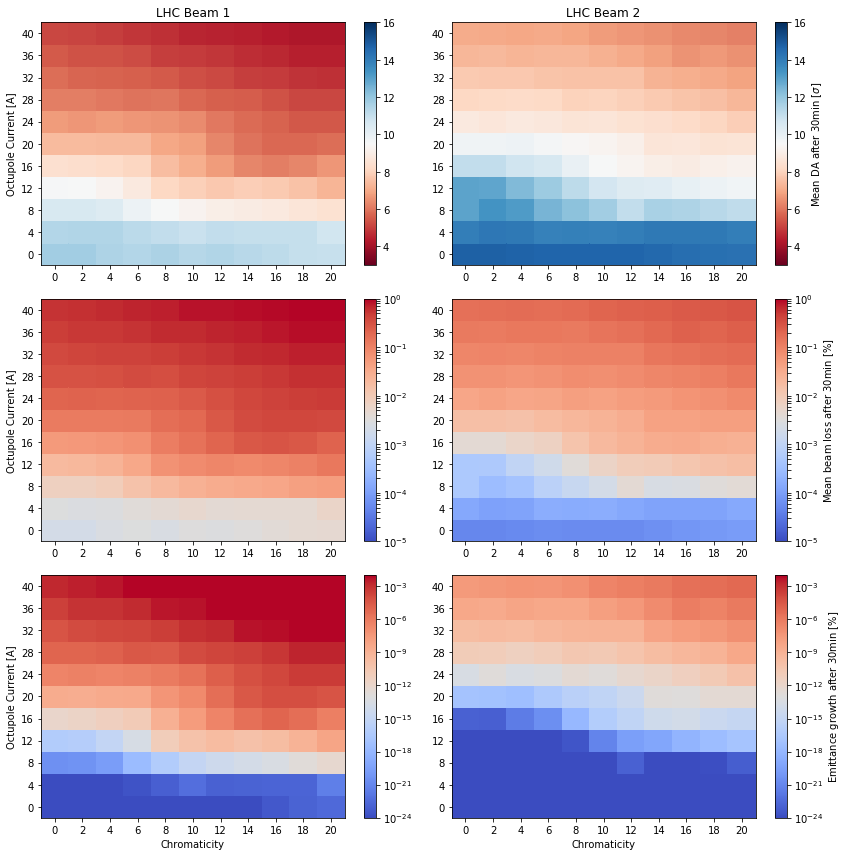

In [14]:
loss_lim1, loss_lim2 = 1e-5, 1e0

fig = plt.figure(figsize=[12,12])
ax1 = fig.add_subplot(321)            
ax2 = fig.add_subplot(322)            
ax3 = fig.add_subplot(323)            
ax4 = fig.add_subplot(324)  
ax5 = fig.add_subplot(325)            
ax6 = fig.add_subplot(326)  

X,Y,Z = prepare_pcolormesh(data_B1, 'chroma','ioct','meanda',offset=[-1,-2,0])

ax1.set_title('LHC Beam 1')
# ax1.set_xlabel("Chromaticity")
ax1.set_ylabel("Octupole Current [A]")

im1 = ax1.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=3, vmax=16)
fig.colorbar(im1,ax=ax1)
# fig.colorbar(im1,label=r'Mean DA after 30min [$\sigma$]',ax=ax1)

ax1.set_xticks(np.array(range(0,21,2)))
ax1.set_yticks(np.array(range(0,41,4)))


X,Y,Z = prepare_pcolormesh(data_B1, 'chroma','ioct','avgloss',offset=[-1,-2,0],weights=[1,1,100])

# ax3.set_xlabel("Chromaticity")
ax3.set_ylabel("Octupole Current [A]")

im3 = ax3.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                                         norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
# fig.colorbar(im3,label=r'Mean beam loss after 30min [$\%$]',ax=ax3)
fig.colorbar(im3,ax=ax3)

ax3.set_xticks(np.array(range(0,21,2)))
ax3.set_yticks(np.array(range(0,41,4)))

X,Y,Z = prepare_pcolormesh(data_B1, 'chroma','ioct','eg_mean',offset=[-1,-2,0],weights=[1,1,100])

ax5.set_xlabel("Chromaticity")
ax5.set_ylabel("Octupole Current [A]")

im5 = ax5.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=1e-24, vmax=1e-2,
                                         norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
# fig.colorbar(im5,label=r'Emittance growth after 30min [$\%$]',ax=ax5)
fig.colorbar(im5,ax=ax5)

ax5.set_xticks(np.array(range(0,21,2)))
ax5.set_yticks(np.array(range(0,41,4)))


# BEAM 2

X,Y,Z = prepare_pcolormesh(data_B2, 'chroma','ioct','meanda',offset=[-1,-2,0])

ax2.set_title('LHC Beam 2')
# ax2.set_xlabel("Chromaticity")
# ax2.set_ylabel("Octupole Current [A]")

im1 = ax2.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=3, vmax=16)
fig.colorbar(im1,label=r'Mean DA after 30min [$\sigma$]',ax=ax2)

ax2.set_xticks(np.array(range(0,21,2)))
ax2.set_yticks(np.array(range(0,41,4)))


X,Y,Z = prepare_pcolormesh(data_B2, 'chroma','ioct','avgloss',offset=[-1,-2,0],weights=[1,1,100])

# ax4.set_xlabel("Chromaticity")
# ax4.set_ylabel("Octupole Current [A]")

im4 = ax4.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                     norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
fig.colorbar(im4,label=r'Mean beam loss after 30min [$\%$]',ax=ax4)

ax4.set_xticks(np.array(range(0,21,2)))
ax4.set_yticks(np.array(range(0,41,4)))


X,Y,Z = prepare_pcolormesh(data_B2, 'chroma','ioct','eg_mean',offset=[-1,-2,0],weights=[1,1,100])

ax6.set_xlabel("Chromaticity")
# ax6.set_ylabel("Octupole Current [A]")

im6 = ax6.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=1e-24, vmax=1e-2,
                     norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
fig.colorbar(im6,label=r'Emittance growth after 30min [$\%$]',ax=ax6)

ax6.set_xticks(np.array(range(0,21,2)))
ax6.set_yticks(np.array(range(0,41,4)))

plt.tight_layout()
plt.show()

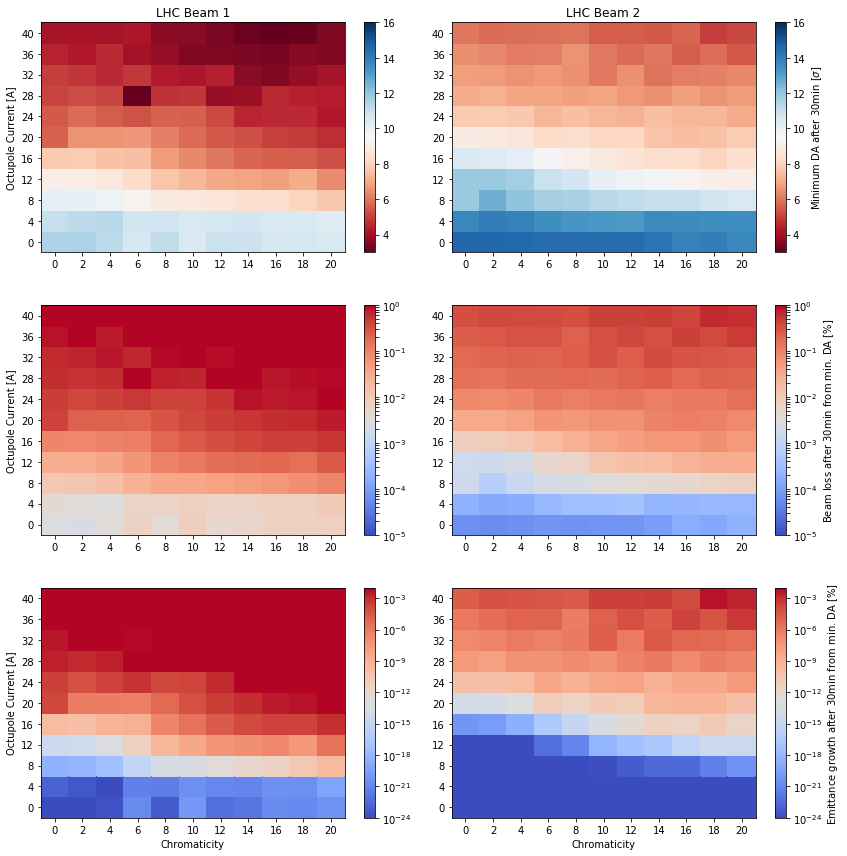

In [41]:
loss_lim1, loss_lim2 = 1e-5, 1e0

fig = plt.figure(figsize=[12,12])
ax1 = fig.add_subplot(321)            
ax2 = fig.add_subplot(322)            
ax3 = fig.add_subplot(323)            
ax4 = fig.add_subplot(324)  
ax5 = fig.add_subplot(325)            
ax6 = fig.add_subplot(326)  

X,Y,Z = prepare_pcolormesh(data_B1, 'chroma','ioct','minda',offset=[-1,-2,0])

ax1.set_title('LHC Beam 1')
# ax1.set_xlabel("Chromaticity")
ax1.set_ylabel("Octupole Current [A]")

im1 = ax1.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=3, vmax=16)
fig.colorbar(im1,ax=ax1)
# fig.colorbar(im1,label=r'Mean DA after 30min [$\sigma$]',ax=ax1)

ax1.set_xticks(np.array(range(0,21,2)))
ax1.set_yticks(np.array(range(0,41,4)))


X,Y,Z = prepare_pcolormesh(data_B1, 'chroma','ioct','minloss',offset=[-1,-2,0],weights=[1,1,100])

# ax3.set_xlabel("Chromaticity")
ax3.set_ylabel("Octupole Current [A]")

im3 = ax3.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                                         norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
# fig.colorbar(im3,label=r'Mean beam loss after 30min [$\%$]',ax=ax3)
fig.colorbar(im3,ax=ax3)

ax3.set_xticks(np.array(range(0,21,2)))
ax3.set_yticks(np.array(range(0,41,4)))

X,Y,Z = prepare_pcolormesh(data_B1, 'chroma','ioct','eg_min',offset=[-1,-2,0],weights=[1,1,100])

ax5.set_xlabel("Chromaticity")
ax5.set_ylabel("Octupole Current [A]")

im5 = ax5.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=1e-24, vmax=1e-2,
                                         norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
# fig.colorbar(im5,label=r'Emittance growth after 30min [$\%$]',ax=ax5)
fig.colorbar(im5,ax=ax5)

ax5.set_xticks(np.array(range(0,21,2)))
ax5.set_yticks(np.array(range(0,41,4)))


# BEAM 2

X,Y,Z = prepare_pcolormesh(data_B2, 'chroma','ioct','minda',offset=[-1,-2,0])

ax2.set_title('LHC Beam 2')
# ax2.set_xlabel("Chromaticity")
# ax2.set_ylabel("Octupole Current [A]")

im1 = ax2.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=3, vmax=16)
fig.colorbar(im1,label=r'Minimum DA after 30min [$\sigma$]',ax=ax2)

ax2.set_xticks(np.array(range(0,21,2)))
ax2.set_yticks(np.array(range(0,41,4)))


X,Y,Z = prepare_pcolormesh(data_B2, 'chroma','ioct','minloss',offset=[-1,-2,0],weights=[1,1,100])

# ax4.set_xlabel("Chromaticity")
# ax4.set_ylabel("Octupole Current [A]")

im4 = ax4.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                     norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
fig.colorbar(im4,label=r'Beam loss after 30min from min. DA [$\%$]',ax=ax4)

ax4.set_xticks(np.array(range(0,21,2)))
ax4.set_yticks(np.array(range(0,41,4)))


X,Y,Z = prepare_pcolormesh(data_B2, 'chroma','ioct','eg_min',offset=[-1,-2,0],weights=[1,1,100])

ax6.set_xlabel("Chromaticity")
# ax6.set_ylabel("Octupole Current [A]")

im6 = ax6.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=1e-24, vmax=1e-2,
                     norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
fig.colorbar(im6,label=r'Emittance growth after 30min from min. DA [$\%$]',ax=ax6)

ax6.set_xticks(np.array(range(0,21,2)))
ax6.set_yticks(np.array(range(0,41,4)))

plt.tight_layout()
plt.show()

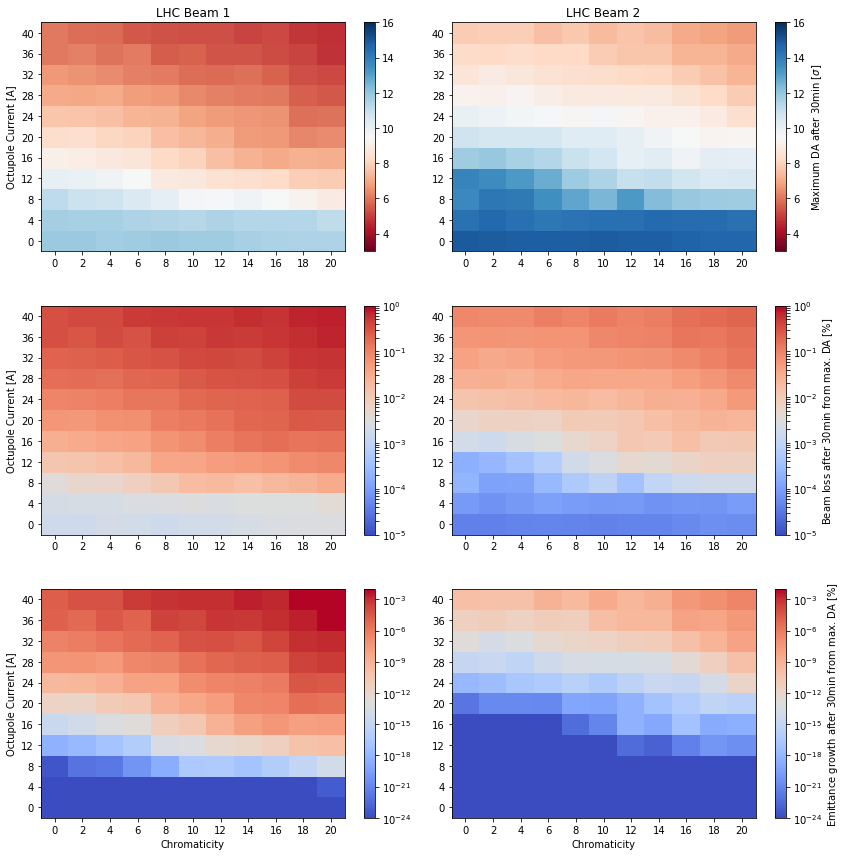

In [42]:
loss_lim1, loss_lim2 = 1e-5, 1e0

fig = plt.figure(figsize=[12,12])
ax1 = fig.add_subplot(321)            
ax2 = fig.add_subplot(322)            
ax3 = fig.add_subplot(323)            
ax4 = fig.add_subplot(324)  
ax5 = fig.add_subplot(325)            
ax6 = fig.add_subplot(326)  

X,Y,Z = prepare_pcolormesh(data_B1, 'chroma','ioct','maxda',offset=[-1,-2,0])

ax1.set_title('LHC Beam 1')
# ax1.set_xlabel("Chromaticity")
ax1.set_ylabel("Octupole Current [A]")

im1 = ax1.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=3, vmax=16)
fig.colorbar(im1,ax=ax1)
# fig.colorbar(im1,label=r'Mean DA after 30min [$\sigma$]',ax=ax1)

ax1.set_xticks(np.array(range(0,21,2)))
ax1.set_yticks(np.array(range(0,41,4)))


X,Y,Z = prepare_pcolormesh(data_B1, 'chroma','ioct','maxloss',offset=[-1,-2,0],weights=[1,1,100])

# ax3.set_xlabel("Chromaticity")
ax3.set_ylabel("Octupole Current [A]")

im3 = ax3.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                                         norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
# fig.colorbar(im3,label=r'Mean beam loss after 30min [$\%$]',ax=ax3)
fig.colorbar(im3,ax=ax3)

ax3.set_xticks(np.array(range(0,21,2)))
ax3.set_yticks(np.array(range(0,41,4)))

X,Y,Z = prepare_pcolormesh(data_B1, 'chroma','ioct','eg_max',offset=[-1,-2,0],weights=[1,1,100])

ax5.set_xlabel("Chromaticity")
ax5.set_ylabel("Octupole Current [A]")

im5 = ax5.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=1e-24, vmax=1e-2,
                                         norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
# fig.colorbar(im5,label=r'Emittance growth after 30min [$\%$]',ax=ax5)
fig.colorbar(im5,ax=ax5)

ax5.set_xticks(np.array(range(0,21,2)))
ax5.set_yticks(np.array(range(0,41,4)))


# BEAM 2

X,Y,Z = prepare_pcolormesh(data_B2, 'chroma','ioct','maxda',offset=[-1,-2,0])

ax2.set_title('LHC Beam 2')
# ax2.set_xlabel("Chromaticity")
# ax2.set_ylabel("Octupole Current [A]")

im1 = ax2.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=3, vmax=16)
fig.colorbar(im1,label=r'Maximum DA after 30min [$\sigma$]',ax=ax2)

ax2.set_xticks(np.array(range(0,21,2)))
ax2.set_yticks(np.array(range(0,41,4)))


X,Y,Z = prepare_pcolormesh(data_B2, 'chroma','ioct','maxloss',offset=[-1,-2,0],weights=[1,1,100])

# ax4.set_xlabel("Chromaticity")
# ax4.set_ylabel("Octupole Current [A]")

im4 = ax4.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                     norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
fig.colorbar(im4,label=r'Beam loss after 30min from max. DA [$\%$]',ax=ax4)

ax4.set_xticks(np.array(range(0,21,2)))
ax4.set_yticks(np.array(range(0,41,4)))


X,Y,Z = prepare_pcolormesh(data_B2, 'chroma','ioct','eg_max',offset=[-1,-2,0],weights=[1,1,100])

ax6.set_xlabel("Chromaticity")
# ax6.set_ylabel("Octupole Current [A]")

im6 = ax6.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=1e-24, vmax=1e-2,
                     norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
fig.colorbar(im6,label=r'Emittance growth after 30min from max. DA [$\%$]',ax=ax6)

ax6.set_xticks(np.array(range(0,21,2)))
ax6.set_yticks(np.array(range(0,41,4)))

plt.tight_layout()
plt.show()

# HL-LHC

Extrapolate the DA and calculate losses and emittance growth for the simulations for HL-LHC carried out by Frederik. 

## Tune scan

In [43]:
_data = []
basedir = '/afs/cern.ch/work/f/fvanderv/public/forpascal/'

for _qx in np.arange(62.255,62.300,0.005):
    for _qy in np.arange(60.280,60.330,0.005):
        _dbname   = '{0}hl10_injection_scan_{1:1.3f}_{2:1.3f}_B1.db'.format(basedir,_qx,_qy)
        try:
            a         = da.davst(_dbname,emit=2.5)
            df        = a.fitda(1,10,0.5,steps=1,verbose=False)

            _data.append([_qx, _qy, df.exda.min(), df.exda.max(), df.exda.mean()])
        except:
            _data.append([_qx, _qy, 0, 0, 0])
        print("Loaded study {0}".format(_dbname),end='\r',flush=True)            
data_B1 = pd.DataFrame(_data,columns=['qx','qy','minda','maxda','meanda'])        

In [46]:
data_B1 = data_B1.assign(eg_mean=emittance_growth_gauss(data_B1['meanda']))
data_B1 = data_B1.assign(eg_min=emittance_growth_gauss(data_B1['minda']))
data_B1 = data_B1.assign(eg_max=emittance_growth_gauss(data_B1['maxda']))

data_B1 = data_B1.assign(avgloss=calculate_loss(data_B1['meanda']))
data_B1 = data_B1.assign(minloss=calculate_loss(data_B1['minda']))
data_B1 = data_B1.assign(maxloss=calculate_loss(data_B1['maxda']))

In [44]:
_data = []
basedir = '/afs/cern.ch/work/f/fvanderv/public/forpascal/'

for _qx in np.arange(62.255,62.300,0.005):
    for _qy in np.arange(60.280,60.330,0.005):
        _dbname   = '{0}hl10_injection_scan_{1:1.3f}_{2:1.3f}_B4.db'.format(basedir,_qx,_qy)   
        try:
            a         = da.davst(_dbname,emit=2.5)
            df        = a.fitda(1,10,0.5,steps=1,verbose=False)

            _data.append([_qx, _qy, df.exda.min(), df.exda.max(), df.exda.mean()])
        except:
            _data.append([_qx, _qy, 0, 0, 0])
        print("Loaded study {0}".format(_dbname),end='\r',flush=True)                        
data_B2 = pd.DataFrame(_data,columns=['qx','qy','minda','maxda','meanda'])        

In [45]:
data_B2 = data_B2.assign(eg_mean=emittance_growth_gauss(data_B2['meanda']))
data_B2 = data_B2.assign(eg_min=emittance_growth_gauss(data_B2['minda']))
data_B2 = data_B2.assign(eg_max=emittance_growth_gauss(data_B2['maxda']))

data_B2 = data_B2.assign(avgloss=calculate_loss(data_B2['meanda']))
data_B2 = data_B2.assign(minloss=calculate_loss(data_B2['minda']))
data_B2 = data_B2.assign(maxloss=calculate_loss(data_B2['maxda']))

In [47]:
data_B1.to_hdf('da_results.h5', 'HLLHCB1_tune_scan', table=True, mode='w')
data_B2.to_hdf('da_results.h5', 'HLLHCB2_tune_scan', table=True, mode='w')

### Plot the data

/home/phermes/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


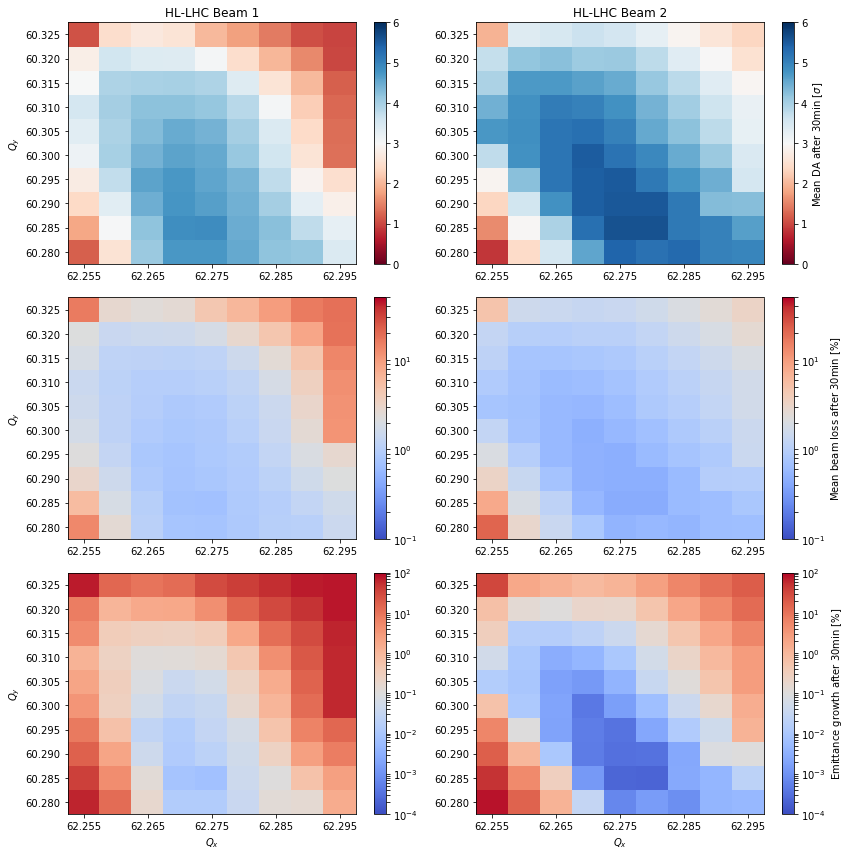

In [48]:
loss_lim1, loss_lim2 = 0.1, 50
da_lim1, da_lim2 = 0, 6
offset = [-0.0025,-0.0025,0]

fig = plt.figure(figsize=[12,12])
ax1 = fig.add_subplot(321)            
ax2 = fig.add_subplot(322)            
ax3 = fig.add_subplot(323)            
ax4 = fig.add_subplot(324)  
ax5 = fig.add_subplot(325)            
ax6 = fig.add_subplot(326)  

X,Y,Z = prepare_pcolormesh(data_B1, 'qx','qy','meanda',offset=[-0.0025,-0.0025,0])

ax1.set_title('HL-LHC Beam 1')
# ax1.set_xlabel("Chromaticity")
ax1.set_ylabel(r"$Q_y$")

im1 = ax1.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=da_lim1, vmax=da_lim2)
fig.colorbar(im1,ax=ax1)
# fig.colorbar(im1,label=r'Mean DA after 30min [$\sigma$]',ax=ax1)


X,Y,Z = prepare_pcolormesh(data_B1, 'qx','qy','avgloss',offset=offset,weights=[1,1,100])

# ax3.set_xlabel("Chromaticity")
ax3.set_ylabel(r"$Q_y$")

im3 = ax3.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                                         norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
# fig.colorbar(im3,label=r'Mean beam loss after 30min [$\%$]',ax=ax3)
fig.colorbar(im3,ax=ax3)



X,Y,Z = prepare_pcolormesh(data_B1, 'qx','qy','eg_mean',offset=offset,weights=[1,1,100])

ax5.set_xlabel(r"$Q_x$")
ax5.set_ylabel(r"$Q_y$")

im5 = ax5.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=0.0001, vmax=100,
                                         norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
# fig.colorbar(im5,label=r'Emittance growth after 30min [$\%$]',ax=ax5)
fig.colorbar(im5,ax=ax5)




# # BEAM 2

X,Y,Z = prepare_pcolormesh(data_B2, 'qx','qy','meanda',offset=[-0.0025,-0.0025,0])

ax2.set_title('HL-LHC Beam 2')
# ax2.set_xlabel("Chromaticity")
# ax2.set_ylabel("Octupole Current [A]")

im1 = ax2.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=da_lim1, vmax=da_lim2)
fig.colorbar(im1,label=r'Mean DA after 30min [$\sigma$]',ax=ax2)

# ax2.set_xticks(np.arange(62.255,62.300,0.010))
# ax2.set_yticks(np.arange(60.280,60.330,0.005))


X,Y,Z = prepare_pcolormesh(data_B2, 'qx','qy','avgloss',offset=offset,weights=[1,1,100])

# ax4.set_xlabel("Chromaticity")
# ax4.set_ylabel("Octupole Current [A]")

im4 = ax4.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                     norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
fig.colorbar(im4,label=r'Mean beam loss after 30min [$\%$]',ax=ax4)




X,Y,Z = prepare_pcolormesh(data_B2, 'qx','qy','eg_mean',offset=offset,weights=[1,1,100])

ax6.set_xlabel(r"$Q_x$")
# ax6.set_ylabel("Octupole Current [A]")

im6 = ax6.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=0.0001, vmax=1e2,
                     norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
fig.colorbar(im6,label=r'Emittance growth after 30min [$\%$]',ax=ax6)



for ax in fig.axes:
    ax.set_xticks(np.arange(62.255,62.300,0.010))
    ax.set_yticks(np.arange(60.280,60.330,0.005))

plt.tight_layout()
plt.show()

/home/phermes/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


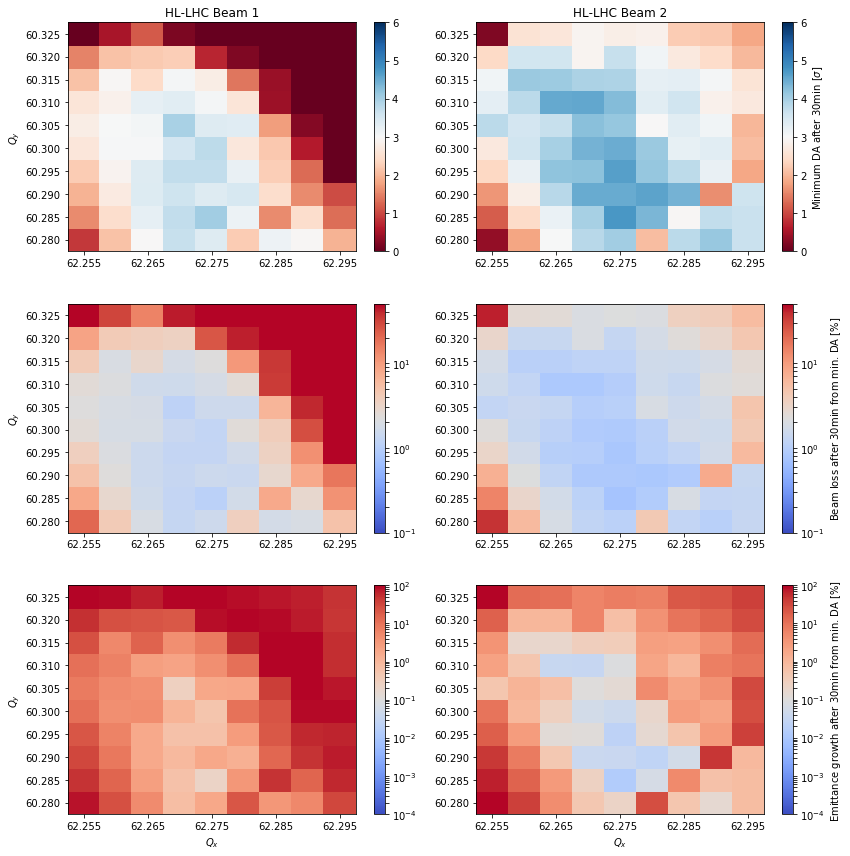

In [52]:
loss_lim1, loss_lim2 = 0.1, 50
da_lim1, da_lim2 = 0, 6
offset = [-0.0025,-0.0025,0]

fig = plt.figure(figsize=[12,12])
ax1 = fig.add_subplot(321)            
ax2 = fig.add_subplot(322)            
ax3 = fig.add_subplot(323)            
ax4 = fig.add_subplot(324)  
ax5 = fig.add_subplot(325)            
ax6 = fig.add_subplot(326)  

X,Y,Z = prepare_pcolormesh(data_B1, 'qx','qy','minda',offset=[-0.0025,-0.0025,0])

ax1.set_title('HL-LHC Beam 1')
# ax1.set_xlabel("Chromaticity")
ax1.set_ylabel(r"$Q_y$")

im1 = ax1.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=da_lim1, vmax=da_lim2)
fig.colorbar(im1,ax=ax1)
# fig.colorbar(im1,label=r'Mean DA after 30min [$\sigma$]',ax=ax1)


X,Y,Z = prepare_pcolormesh(data_B1, 'qx','qy','minloss',offset=offset,weights=[1,1,100])

# ax3.set_xlabel("Chromaticity")
ax3.set_ylabel(r"$Q_y$")

im3 = ax3.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                                         norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
# fig.colorbar(im3,label=r'Mean beam loss after 30min [$\%$]',ax=ax3)
fig.colorbar(im3,ax=ax3)



X,Y,Z = prepare_pcolormesh(data_B1, 'qx','qy','eg_min',offset=offset,weights=[1,1,100])

ax5.set_xlabel(r"$Q_x$")
ax5.set_ylabel(r"$Q_y$")

im5 = ax5.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=0.0001, vmax=100,
                                         norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
# fig.colorbar(im5,label=r'Emittance growth after 30min [$\%$]',ax=ax5)
fig.colorbar(im5,ax=ax5)




# # BEAM 2

X,Y,Z = prepare_pcolormesh(data_B2, 'qx','qy','minda',offset=[-0.0025,-0.0025,0])

ax2.set_title('HL-LHC Beam 2')
# ax2.set_xlabel("Chromaticity")
# ax2.set_ylabel("Octupole Current [A]")

im1 = ax2.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=da_lim1, vmax=da_lim2)
fig.colorbar(im1,label=r'Minimum DA after 30min [$\sigma$]',ax=ax2)

# ax2.set_xticks(np.arange(62.255,62.300,0.010))
# ax2.set_yticks(np.arange(60.280,60.330,0.005))


X,Y,Z = prepare_pcolormesh(data_B2, 'qx','qy','minloss',offset=offset,weights=[1,1,100])

# ax4.set_xlabel("Chromaticity")
# ax4.set_ylabel("Octupole Current [A]")

im4 = ax4.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                     norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
fig.colorbar(im4,label=r'Beam loss after 30min from min. DA [$\%$]',ax=ax4)




X,Y,Z = prepare_pcolormesh(data_B2, 'qx','qy','eg_min',offset=offset,weights=[1,1,100])

ax6.set_xlabel(r"$Q_x$")
# ax6.set_ylabel("Octupole Current [A]")

im6 = ax6.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=0.0001, vmax=1e2,
                     norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
fig.colorbar(im6,label=r'Emittance growth after 30min from min. DA [$\%$]',ax=ax6)



for ax in fig.axes:
    ax.set_xticks(np.arange(62.255,62.300,0.010))
    ax.set_yticks(np.arange(60.280,60.330,0.005))

plt.tight_layout()
plt.show()

/home/phermes/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


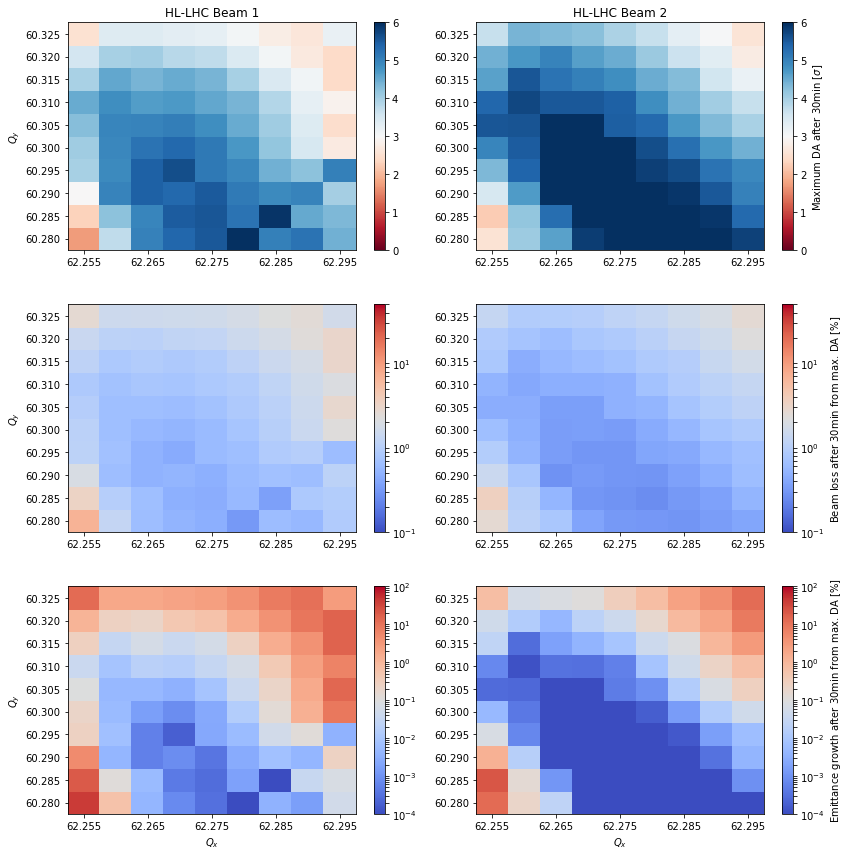

In [51]:
loss_lim1, loss_lim2 = 0.1, 50
da_lim1, da_lim2 = 0, 6
offset = [-0.0025,-0.0025,0]

fig = plt.figure(figsize=[12,12])
ax1 = fig.add_subplot(321)            
ax2 = fig.add_subplot(322)            
ax3 = fig.add_subplot(323)            
ax4 = fig.add_subplot(324)  
ax5 = fig.add_subplot(325)            
ax6 = fig.add_subplot(326)  

X,Y,Z = prepare_pcolormesh(data_B1, 'qx','qy','maxda',offset=[-0.0025,-0.0025,0])

ax1.set_title('HL-LHC Beam 1')
# ax1.set_xlabel("Chromaticity")
ax1.set_ylabel(r"$Q_y$")

im1 = ax1.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=da_lim1, vmax=da_lim2)
fig.colorbar(im1,ax=ax1)
# fig.colorbar(im1,label=r'Mean DA after 30min [$\sigma$]',ax=ax1)


X,Y,Z = prepare_pcolormesh(data_B1, 'qx','qy','maxloss',offset=offset,weights=[1,1,100])

# ax3.set_xlabel("Chromaticity")
ax3.set_ylabel(r"$Q_y$")

im3 = ax3.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                                         norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
# fig.colorbar(im3,label=r'Mean beam loss after 30min [$\%$]',ax=ax3)
fig.colorbar(im3,ax=ax3)



X,Y,Z = prepare_pcolormesh(data_B1, 'qx','qy','eg_max',offset=offset,weights=[1,1,100])

ax5.set_xlabel(r"$Q_x$")
ax5.set_ylabel(r"$Q_y$")

im5 = ax5.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=0.0001, vmax=100,
                                         norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
# fig.colorbar(im5,label=r'Emittance growth after 30min [$\%$]',ax=ax5)
fig.colorbar(im5,ax=ax5)




# # BEAM 2

X,Y,Z = prepare_pcolormesh(data_B2, 'qx','qy','maxda',offset=[-0.0025,-0.0025,0])

ax2.set_title('HL-LHC Beam 2')
# ax2.set_xlabel("Chromaticity")
# ax2.set_ylabel("Octupole Current [A]")

im1 = ax2.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=da_lim1, vmax=da_lim2)
fig.colorbar(im1,label=r'Maximum DA after 30min [$\sigma$]',ax=ax2)

# ax2.set_xticks(np.arange(62.255,62.300,0.010))
# ax2.set_yticks(np.arange(60.280,60.330,0.005))


X,Y,Z = prepare_pcolormesh(data_B2, 'qx','qy','maxloss',offset=offset,weights=[1,1,100])

# ax4.set_xlabel("Chromaticity")
# ax4.set_ylabel("Octupole Current [A]")

im4 = ax4.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                     norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
fig.colorbar(im4,label=r'Beam loss after 30min from max. DA [$\%$]',ax=ax4)




X,Y,Z = prepare_pcolormesh(data_B2, 'qx','qy','eg_max',offset=offset,weights=[1,1,100])

ax6.set_xlabel(r"$Q_x$")
# ax6.set_ylabel("Octupole Current [A]")

im6 = ax6.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=0.0001, vmax=1e2,
                     norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
fig.colorbar(im6,label=r'Emittance growth after 30min from max. DA [$\%$]',ax=ax6)



for ax in fig.axes:
    ax.set_xticks(np.arange(62.255,62.300,0.010))
    ax.set_yticks(np.arange(60.280,60.330,0.005))

plt.tight_layout()
plt.show()